In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pathlib 
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

import PT_files.save_load as sl
from DnCNN_NP.layers  import relu

import time 
from collections import OrderedDict

In [2]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
name = '6k_model_wb_e800_lys20_58feat.pth'

# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

Shape of test set= (108, 1, 6000, 6000)


**TO-DO**

- Get `np_Conv2d` working (ie. the one that uses `signal.correlate2d`), which means getting similar values to the pytorch values.
    - This means actually looping through proper elements of the input_data - **Current Status: In Progress**
    - This means actually looping through both the input and output channels for the weights kernels - **Current Status: In Progress**
    - Look at the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to see the equation we want to replicate in NumPy 
        - Check that results are similar within values using `np.allclose()` and checking the `atol` & `rtol` values - **Current Status: In Progress**
- **^ THIS IS TAKING WAY TOO LONG. FOR THE FIRST LAYER IT ONLY TAKES ~ 1 MINUTE WITH CORRELATE2D, BUT FOR THE SECOND LAYER IT IS 58 TIMES LONGER DUE TO NOW LOOPING OVER INPUT & OUTPUT CHANNELS**

- Once this is done want to work on speeding up the code
- This means updating `np_Conv2d` to work with (`fftconvolve`)
    - This is faster if just simply replacing it with `signal.correlate2d()`, but more importantly it allows for broadcasting
        - To enable this broadcasting and thus do away with all the for loops we need to reshape the input data and weights from 4D arrays to 5D arrays (see picture on phone for better understanding of the axis's we need to reshape to 1 to allow this to happen
        
- **Check out notebook `10B.ipynb` for links to low level convolutions (ie. doing the actual cross-correlation yourself). Seems promising!** ** *<----- DO THIS* **
    - Might be helpful to look into this, so I can understand how the broadcasting is supposed to happen. This will also allow me to really nail down the raw machinery of what is happening within a convolution layer.
   

# Testing just the cross-correlation to see what's up. 

The collapsed cells below are showing even for the first convolution layer that the results are not within round off error between numpy implementation and pytorch. Want to investigate the `signal.correlate2d()` because in the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for its `nn.Conv2d` there is a sum over the input channels correlations

In [3]:
input_data = sample[0]
prefix = 'layers.0.0.'
weights_dict = weights
padding = 'same'
dilation=1
stride = 1

In [4]:
if len(input_data.shape) == 4:

    batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)

elif len(input_data.shape) == 3:

    input_data = input_data.reshape((1, 1, 6000 , 6000))
    batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)

# Load the weights and biases needed for a convolution
# then take off gpu memory, move to CPU memory,
# and lastly transform to numpy
weight = weights_dict[str(prefix) + 'weight']
weight = weight.detach().cpu().numpy()
bias = weights_dict[str(prefix) + 'bias']
bias = bias.detach().cpu().numpy()

# Calculate the kernel size and output channels from
# the loaded weights from above
kernel_size = weight[0][0].shape
output_channels = len(weight)

# Convert string padding into numerical padding
# Using strings allow for one variable to account for padding & mode (see signal.correlated2d)
mode = padding
if mode == "same":
    padding = 1
elif mode == "valid":
    padding = 0

# Calculations for the output H and W dimensions
height_out = ((height + (2*padding) - dilation * (kernel_size[0] - 1) - 1) / stride) + 1
height_out = int(height_out)
width_out = ((width + (2*padding) - dilation * (kernel_size[1] - 1) - 1) / stride) + 1
width_out = int(width_out)

# Create empty array of correct output dimensions
output = np.empty((batch_size, output_channels, height_out, width_out))

In [5]:
# Place the cross correlated elements into the newly created 
# empty array of correct output dimensions
loop_start = time.perf_counter()

for i in range(batch_size):
    for j in range(output_channels):
        for k in range(input_channels):
            # See PyTorch docs for this eqn: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            # output[i, j, :, :] = bias[j] + signal.fftconvolve(input_data[i][k], weight[j][k][::-1, ::-1], mode=mode)
            output[i, j, :, :] += signal.correlate2d(input_data[i][k], weight[j][k], mode=mode)
        output[i, j, :, :] += bias[j]
loop_end = time.perf_counter()
print('Convolution loop takes', loop_end-loop_start, 'seconds')

Convolution loop takes 56.33936107199406 seconds


In [7]:
np_conv_out = np_Conv2d(input_data=sample[0], weights_dict=weights, prefix='layers.0.0.')

Getting input dimensions takes 5.429988959804177e-06 seconds
Loading the weights takes 0.00034999400668311864 seconds
Getting output dimensions takes 0.00015999800234567374 seconds
Convolution loop takes 57.75156341500406 seconds


In [8]:
np.allclose(output, np_conv_out)

True

In [9]:
np_conv_out

array([[[[-0.28845596, -0.26834202, -0.25972748, ..., -0.2693426 ,
          -0.28377205, -0.2945897 ],
         [-0.25479087, -0.29260966, -0.27399468, ..., -0.30623531,
          -0.2845577 , -0.29456601],
         [-0.26810479, -0.24981168, -0.27571946, ..., -0.26672465,
          -0.28597289, -0.27905631],
         ...,
         [-0.25859573, -0.29884547, -0.25435746, ..., -0.25622407,
          -0.29536635, -0.34330356],
         [-0.26425636, -0.25856969, -0.2639792 , ..., -0.27607155,
          -0.3280625 , -0.31927085],
         [-0.26634461, -0.30249953, -0.33001661, ..., -0.32846338,
          -0.31841132, -0.31078395]],

        [[ 0.28756422,  0.32044411,  0.29660699, ...,  0.29815125,
           0.26655075,  0.2351355 ],
         [ 0.24227971,  0.28619757,  0.30876189, ...,  0.2620208 ,
           0.29355097,  0.25883532],
         [ 0.26390964,  0.32980204,  0.29279879, ...,  0.34502286,
           0.31922618,  0.27175131],
         ...,
         [ 0.25560951,  0.33806646

# Testing the difference between np_Conv2d and PyTorch for first layer of DnCNN (ie. (N, Cin, H, W) == (1, 1, 6k, 6k))

In [3]:
def np_Conv2d(input_data, weights_dict, prefix, stride=1, padding="same", dilation=1):
    """
    Numpy implementation of the PyTorch Conv2d layer that uses the 
    learned PyTorch weights in the model.
    
    Parameters:
    -----------
    input_data: nd.array
        Input data of shape '(batch_size, in_channels, height, width)'
    weights_dict: OrderedDict
        weights_dict['weight']: torch.Tensor
            Weights tensor of shape '(out_channels, in_channels, kernel_size[0], kernel_size[1])'
        weights_dict['bias']: torch.Tensor
            Bias tensor of shape '(out_channels)'
    stride: int, optional
        The number of entries by which the filter is moved at each step.
        Defaults to 1
    padding: str, optional
        What padding strategy to use for this conv layer. Defaults to "same",
        which pads the layer such that the output has the same height and width
        as the input when the stride = 1. Specifically makes output of
        scipy.correlate2d have same shape as in1. An alternative option is "valid",
        which means no padding is done and the output has smaller dimensions
        than the input.
    dilation: int, optional
        Spacing between kernel elements.
        Defaults to 1.
     
        
    Returns:
    --------
    output: nd.array
        Array output of the convolution step with shape
        `(batch_size, out_channels, out_height, out_width)`.
    
    """
    
    # Checking to see if a single sample or a batch of samples is given.
    # If batch take the batch_size, in_channels, H, and W
    # If single sample is given reshape so the values above can be calculated
    dimensions_start = time.perf_counter()
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 6000 , 6000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    dimensions_end = time.perf_counter()
    print('Getting input dimensions takes', dimensions_end-dimensions_start, 'seconds')

    # Load the weights and biases needed for a convolution
    # then take off gpu memory, move to CPU memory,
    # and lastly transform to numpy
    loading_start = time.perf_counter()
    weight = weights_dict[str(prefix) + 'weight']
    weight = weight.detach().cpu().numpy()
    bias = weights_dict[str(prefix) + 'bias']
    bias = bias.detach().cpu().numpy()
    
    # Calculate the kernel size and output channels from
    # the loaded weights from above
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    loading_end = time.perf_counter()
    print('Loading the weights takes', loading_end-loading_start, 'seconds')
    
    # Convert string padding into numerical padding
    # Using strings allow for one variable to account for padding & mode (see signal.correlated2d)
    out_dimensions_start = time.perf_counter()
    mode = padding
    if mode == "same":
        padding = 1
    elif mode == "valid":
        padding = 0
    
    # Calculations for the output H and W dimensions
    height_out = ((height + (2*padding) - dilation * (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - dilation * (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)

    # Create empty array of correct output dimensions
    # output = np.empty((batch_size, output_channels, height_out, width_out))
    output = np.zeros((batch_size, output_channels, height_out, width_out))
    out_dimensions_end = time.perf_counter()
    print('Getting output dimensions takes', out_dimensions_end-out_dimensions_start, 'seconds')
    
    # Place the cross correlated elements into the newly created 
    # empty array of correct output dimensions
    loop_start = time.perf_counter()
    
    for i in range(batch_size):
        for j in range(output_channels):
            for k in range(input_channels):
                # See PyTorch docs for this eqn: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
                # output[i, j, :, :] = bias[j] + signal.fftconvolve(input_data[i][k], weight[j][k][::-1, ::-1], mode=mode)
                output[i, j, :, :] = bias[j] + signal.correlate2d(input_data[i][k], weight[j][k], mode=mode)

    loop_end = time.perf_counter()
    print('Convolution loop takes', loop_end-loop_start, 'seconds')
    
    return output


def np_BatchNorm2d(input_data, prefix, weights_dict, epsilon=1e-5):
    
    x = input_data
    
    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1)
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
        
        
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    return output

In [4]:
np_conv_out = np_Conv2d(input_data=sample[0], weights_dict=weights, prefix='layers.0.0.')

Getting input dimensions takes 4.298999556340277e-06 seconds
Loading the weights takes 0.0003327610029373318 seconds
Getting output dimensions takes 0.00013068200496491045 seconds
Convolution loop takes 57.49262410499796 seconds


In [5]:
test_sample = sample[0]
test_sample = test_sample.reshape((1, 1, 6000 , 6000))
test_sample = torch.as_tensor(test_sample)
test_sample = test_sample.to(device)
# sample_torch = torch.from_numpy(sample)
params = OrderedDict({'weight': weights['layers.0.0.weight'], 'bias': weights['layers.0.0.bias']})

model = nn.Conv2d(in_channels=1, out_channels=58, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model.to(device)
model.load_state_dict(params)
pytorch_conv_out = model(test_sample)
pytorch_conv_out = pytorch_conv_out.detach().cpu().numpy()

Trying to find the elements where the pytorch and numpy versions disagree due to seeing below that many pixels in each feature map agree between the two implementations, but we know overall (ie. via `np.allclose` that the implementations are different to a non-round off degree)

In [22]:
idx = 0

ids = np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx])
problem_elems = np.where(ids == False)

In [26]:
problem_elems

(array([   3,    3,    3, ..., 5979, 5979, 5980]),
 array([2788, 3126, 3197, ..., 3030, 3043, 2999]))

In [35]:
len(problem_elems[0])

61230

In [36]:
np_conv_out.shape

(1, 58, 6000, 6000)

In [18]:
idx = 0
print(f"Feature map {idx}")
print('Is close =', np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx]))
print('All close =', np.allclose(pytorch_conv_out[0][idx], np_conv_out[0][idx]))
print()

idx = 1
print(f"Feature map {idx}")
print('Is close =', np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx]))
print('All close =', np.allclose(pytorch_conv_out[0][idx], np_conv_out[0][idx]))
print()

idx = 2
print(f"Feature map {idx}")
print('Is close =', np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx]))
print('All close =', np.allclose(pytorch_conv_out[0][idx], np_conv_out[0][idx]))
print()

idx = 3
print(f"Feature map {idx}")
print('Is close =', np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx]))
print('All close =', np.allclose(pytorch_conv_out[0][idx], np_conv_out[0][idx]))
print()

Feature map 0
Is close = [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
All close = False

Feature map 1
Is close = [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
All close = False

Feature map 2
Is close = [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
All close = False

Feature map 3
Is close = [[ True  True  True ...  True  True  True]
 [ True 

In [10]:
idx = 1
np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [11]:
idx = 2
np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [13]:
idx = 3
np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [14]:
idx = 4
np.isclose(pytorch_conv_out[0][idx], np_conv_out[0][idx])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [9]:
feat_map = 0
start=1400
end=1600
print(pytorch_conv_out.shape)
# print(np_conv_out.shape)
# print(pytorch_conv_out[0][feat_map][start:end,start:end])
# print(np_conv_out[0][feat_map][start:end,start:end])

(1, 58, 6000, 6000)


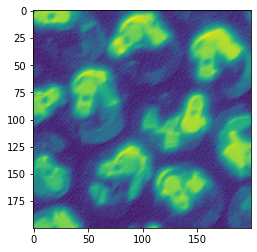

In [10]:
plt.imshow(pytorch_conv_out[0][feat_map][start:end, start:end])

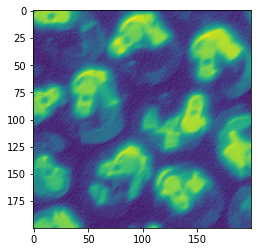

In [11]:
plt.imshow(np_conv_out[0][feat_map][start:end, start:end])

In [14]:
print(np.allclose(pytorch_conv_out, np_conv_out, rtol=1e-05, atol=1e-06))

False


# Testing between first conv layer + 2nd layer block of conv & batchnorm between numpy models & pytorch models

In [15]:
np_conv_out0 = np_Conv2d(input_data=sample[0], weights_dict=weights, prefix='layers.0.0.')
np_conv_out1 = np_Conv2d(input_data=np_conv_out0, weights_dict=weights, prefix='layers.1.0.')
np_batch_out = np_BatchNorm2d(input_data=np_conv_out1, weights_dict=weights, prefix='layers.1.1.')

Getting input dimensions takes 4.699002602137625e-06 seconds
Loading the weights takes 0.0006847789918538183 seconds
Getting output dimensions takes 2.271300763823092e-05 seconds
Convolution loop takes 48.403654587993515 seconds
Getting input dimensions takes 2.4949986254796386e-06 seconds
Loading the weights takes 0.0008569309866288677 seconds
Getting output dimensions takes 2.7312999009154737e-05 seconds


KeyboardInterrupt: 

In [ ]:
test_sample = sample[:1]
test_sample = torch.as_tensor(test_sample)
test_sample = test_sample.to(device)

# First layer of DnCNN
params = OrderedDict({'weight': weights['layers.0.0.weight'], 'bias': weights['layers.0.0.bias']})

model = nn.Conv2d(in_channels=1, out_channels=58, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model.to(device)
model.load_state_dict(params)
pytorch_out = model(test_sample)

# Start of second layer block.
# First in block is conv layer.
params = OrderedDict({'weight': weights['layers.1.0.weight'], 'bias': weights['layers.1.0.bias']})

model = nn.Conv2d(in_channels=58, out_channels=58, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model.to(device)
model.load_state_dict(params)
pytorch_out = model(pytorch_out)

# Start of second layer block.
# Second in block is batchnorm layer
test_sample = test_sample.to(device)
params = OrderedDict({'weight': weights['layers.1.1.weight'], 'bias': weights['layers.1.1.bias'], 'running_mean': weights['layers.1.1.running_mean'], 'running_var': weights['layers.1.1.running_var']})

model = nn.BatchNorm2d(num_features=58) # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model.to(device)
model.load_state_dict(params)

# Don't forget to change BatchNorm to eval mode!
model.eval()
with torch.no_grad():
    pytorch_norm_out = model(pytorch_out)
    pytorch_norm_out = pytorch_norm_out.detach().cpu().numpy()

In [ ]:
print(np.allclose(pytorch_norm_out, np_batch_out))